In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_PATH = '/kaggle/input/hair-mask-segmentation/dermoscopic_image/'
MASK_PATH = '/kaggle/input/hair-mask-segmentation/hair_mask/'

In [3]:
n_classes = 2

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  500


In [4]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  382
Val Size     :  68
Test Size    :  50


In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
import cv2

# Load your RGB image
rgb_image = cv2.imread(MASK_PATH + df['id'][100] + '.png')

# Convert to grayscale using OpenCV
gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

img=np.asarray(img)
#mask= np.asarray(mask)/255
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

print('Mask Size', np.asarray(gray_image).shape)


Image Size (512, 512, 3)
Mask Size (512, 512, 3)
Mask Size (512, 512)


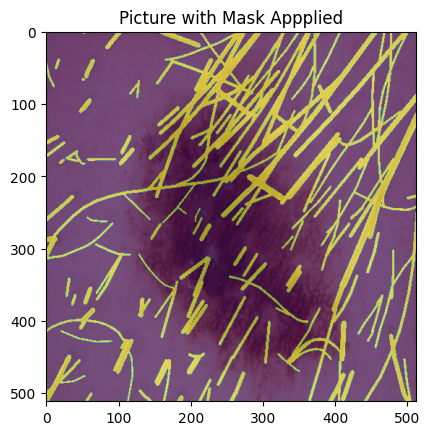

In [6]:
plt.imshow(img)
plt.imshow(gray_image, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [7]:
class Dataset_create(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
         
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
       

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        #extra to make 128,128 to 128,128,1
        # Add an extra dimension to convert it to (128, 128, 1)
        mask = mask[:, :, np.newaxis]
        t2 = T.Compose([T.ToTensor()])
        mask = t2(mask)
        
        
        #print(mask.shape)
        #mask = torch.from_numpy(mask).long()
        #mask = mask.long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1,  64,64).unfold(2,  64,64) 
        #print("ok")
        img_patches  = img_patches.contiguous().view(3,-1,  64,64) 
        #print("ok2")
        img_patches = img_patches.permute(1,0,2,3)
        #print("ok3")
        
        mask_patches = mask.unfold(1,  64,64).unfold(2,  64,64)
        mask_patches = mask_patches.contiguous().view(1,-1,  64,64)
        mask_patches = mask_patches.permute(1,0,2,3)
        
        return img_patches, mask_patches

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256,256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256,256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Dataset_create(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Dataset_create(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)    

In [9]:
import torch
from torch.utils.data import DataLoader


# Assuming each batch contains image and mask tensors
for batch_idx, (images, masks) in enumerate(train_loader):
    # Print the shape of the first batch
    if batch_idx == 0:
        print("Image batch shape:", images.shape)
        print("Mask batch shape:", masks.shape)
    
    # Break after the first batch if you only want to print one iteration
    break


Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


In [10]:
im , mk = train_set[6]
myfiles=[im,mk]
print(mk.shape)
print(im.shape)

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


In [11]:
import numpy as np
import pandas as pd
import os , glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing import image
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset , DataLoader
from torchvision import transforms , utils , datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [13]:
net=smp.Unet('efficientnet-b3', encoder_weights='imagenet', classes=1, activation=None, encoder_depth=5, decoder_channels=[ 256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 142MB/s]


In [14]:
#net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)

optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,  'max', patience=2)
criterion = nn.BCEWithLogitsLoss()
# if net.n_classes > 1:
#     criterion = nn.CrossEntropyLoss()
# else:
#     criterion = nn.BCEWithLogitsLoss()

In [15]:
def dice_calc(gt,pred) :
    pred = torch.sigmoid(pred)
    pred = ((pred) >= .5).float()
    dice_score = (2 * (pred * gt).sum()) / ((pred + gt).sum() + 1e-8)
    
    return dice_score

In [16]:

def train(epoch,epochs,tloader) :
    net.train()
    
    tloader.set_description(f'EPOCH {epoch}')
    epoch_loss = 0
    dice_score = 0
    num_correct = 0    
    
    for images , masks in tloader :
 
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks  = masks.to(device, dtype=torch.float32)
        mask_pred = net(images)

        loss = criterion(mask_pred,masks)
        epoch_loss += loss.item()      
        loss.backward()
        optimizer.step()
    
        running_DS = dice_calc(masks,mask_pred)
        dice_score += running_DS
                
        tloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
    print(' Train Dice Score Epoch : ',dice_score/len(train_loader))
    
def validation(vloader) :
    net.eval()
    vloader.set_description('Validation')
    
    n_val = len(val_loader)
    total = 0
    dice_score = 0
    num_correct = 0
    
    with torch.no_grad():
        for images ,masks in vloader :

            images = images.to(device)
            masks  = masks.to(device)
                
            mask_pred = net(images)
            
            loss = criterion(mask_pred,masks)
            
            running_DS = dice_calc(masks,mask_pred)
            dice_score += running_DS
            
            vloader.set_postfix(loss=loss.item(),accuracy=(running_DS.item()))
        
    print('Validation Dice Score Epoch : ',dice_score/len(val_loader))
            

In [17]:
#worked fine
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

# Define the Dice Score calculation function
def dice_calc(gt, pred):
    pred = torch.sigmoid(pred)
    pred = (pred >= 0.5).float()
    intersection = (pred * gt).sum()
    union = (pred + gt).sum() + 1e-8
    dice_score = (2 * intersection) / union
    return dice_score

# Define the IoU calculation function
def iou_calc(gt, pred):
    pred = torch.sigmoid(pred)
    pred = (pred >= 0.5).float()
    intersection = (pred * gt).sum()
    union = (pred + gt).sum() - intersection + 1e-8
    iou_score = intersection / union
    return iou_score

# Define your model, optimizer, and loss criterion
device = torch.device("cuda:0")
#net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.BCEWithLogitsLoss()

# Training loop
def train(epoch, epochs, tloader):
    net.train()
    tloader.set_description(f'EPOCH {epoch}')
    epoch_loss = 0
    dice_score = 0
    iou_score = 0
    
    for images, masks in tloader:
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)
        mask_pred = net(images)
        
        loss = criterion(mask_pred, masks)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        running_DS = dice_calc(masks, mask_pred)
        dice_score += running_DS
        running_IOU = iou_calc(masks, mask_pred)
        iou_score += running_IOU
        
        tloader.set_postfix(loss=loss.item(), dice_score=running_DS.item(), iou_score=running_IOU.item())
    
    print(f'Train Dice Score Epoch: {dice_score / len(tloader)}')
    print(f'Train IoU Score Epoch: {iou_score / len(tloader)}')

# Validation loop
def validation(vloader):
    net.eval()
    vloader.set_description('Validation')
    
    dice_score = 0
    iou_score = 0
    
    with torch.no_grad():
        for images, masks in vloader:
            images = images.to(device)
            masks = masks.to(device)
            mask_pred = net(images)
            
            running_DS = dice_calc(masks, mask_pred)
            dice_score += running_DS
            running_IOU = iou_calc(masks, mask_pred)
            iou_score += running_IOU
            
            vloader.set_postfix(dice_score=running_DS.item(), iou_score=running_IOU.item())
        
    print(f'Validation Dice Score Epoch: {dice_score / len(vloader)}')
    print(f'Validation IoU Score Epoch: {iou_score / len(vloader)}')


In [18]:
#patch try
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

# Define the Dice Score calculation function
def dice_calc(gt, pred):
    pred = torch.sigmoid(pred)
    pred = (pred >= 0.5).float()
    intersection = (pred * gt).sum()
    union = (pred + gt).sum() + 1e-8
    dice_score = (2 * intersection) / union
    return dice_score

# Define the IoU calculation function
def iou_calc(gt, pred):
    pred = torch.sigmoid(pred)
    pred = (pred >= 0.5).float()
    intersection = (pred * gt).sum()
    union = (pred + gt).sum() - intersection + 1e-8
    iou_score = intersection / union
    return iou_score

# Define your model, optimizer, and loss criterion
device = torch.device("cuda:0")
#net = UNet(n_channels=3, n_classes=1, bilinear=True)
net.to(device=device)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.BCEWithLogitsLoss()

# Training loop
def train(epoch, epochs, tloader, patch=False):
    net.train()
    tloader.set_description(f'EPOCH {epoch}')
    epoch_loss = 0
    dice_score = 0
    iou_score = 0
    
    for images, masks in tloader:
        optimizer.zero_grad()
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)
        
        if patch:
            # Perform patch-wise training
            batch_size, num_patches, num_channels, height, width = images.shape
            images = images.view(-1, num_channels, height, width)
            masks = masks.view(-1, 1, height, width)
            
        mask_pred = net(images)
        
        loss = criterion(mask_pred, masks)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        running_DS = dice_calc(masks, mask_pred)
        dice_score += running_DS
        running_IOU = iou_calc(masks, mask_pred)
        iou_score += running_IOU
        
        tloader.set_postfix(loss=loss.item(), dice_score=running_DS.item(), iou_score=running_IOU.item())
    
    print(f'Train Dice Score Epoch: {dice_score / len(tloader)}')
    print(f'Train IoU Score Epoch: {iou_score / len(tloader)}')

# Validation loop
def validation(vloader, patch=False):
    net.eval()
    vloader.set_description('Validation')
    
    dice_score = 0
    iou_score = 0
    
    with torch.no_grad():
        for images, masks in vloader:
            images = images.to(device)
            masks = masks.to(device)
            
            if patch:
                # Perform patch-wise validation
                batch_size, num_patches, num_channels, height, width = images.shape
                images = images.view(-1, num_channels, height, width)
                masks = masks.view(-1, 1, height, width)
                
            mask_pred = net(images)
            
            running_DS = dice_calc(masks, mask_pred)
            dice_score += running_DS
            running_IOU = iou_calc(masks, mask_pred)
            iou_score += running_IOU
            
            vloader.set_postfix(dice_score=running_DS.item(), iou_score=running_IOU.item())
        
    print(f'Validation Dice Score Epoch: {dice_score / len(vloader)}')
    print(f'Validation IoU Score Epoch: {iou_score / len(vloader)}')


In [19]:
epochs = 40

for epoch in range(epochs) :
    print(epoch+1,'/',epochs)
    with tqdm(train_loader,unit='batch') as tloader : 
        train(epoch,epochs,tloader,patch=False)
    
    with tqdm(val_loader,unit='batch') as vloader:
        validation(vloader,patch=False)

1 / 40


EPOCH 0: 100%|██████████| 24/24 [00:33<00:00,  1.40s/batch, dice_score=0.517, iou_score=0.349, loss=0.263]


Train Dice Score Epoch: 0.40546709299087524
Train IoU Score Epoch: 0.2584465742111206


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.75batch/s, dice_score=0.00019, iou_score=9.49e-5]


Validation Dice Score Epoch: 0.00015772822371218354
Validation IoU Score Epoch: 7.887247920734808e-05
2 / 40


EPOCH 1: 100%|██████████| 24/24 [00:16<00:00,  1.45batch/s, dice_score=0.614, iou_score=0.443, loss=0.227]


Train Dice Score Epoch: 0.5406525731086731
Train IoU Score Epoch: 0.37295565009117126


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.07batch/s, dice_score=0.133, iou_score=0.0712]


Validation Dice Score Epoch: 0.16395880281925201
Validation IoU Score Epoch: 0.08969495445489883
3 / 40


EPOCH 2: 100%|██████████| 24/24 [00:16<00:00,  1.44batch/s, dice_score=0.59, iou_score=0.419, loss=0.206]


Train Dice Score Epoch: 0.6020543575286865
Train IoU Score Epoch: 0.4321994185447693


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.22batch/s, dice_score=0, iou_score=0]


Validation Dice Score Epoch: 0.01781645603477955
Validation IoU Score Epoch: 0.009079664945602417
4 / 40


EPOCH 3: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.697, iou_score=0.535, loss=0.163]


Train Dice Score Epoch: 0.64096999168396
Train IoU Score Epoch: 0.4729391932487488


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.13batch/s, dice_score=0.0528, iou_score=0.0271]


Validation Dice Score Epoch: 0.37705478072166443
Validation IoU Score Epoch: 0.2446017563343048
5 / 40


EPOCH 4: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.621, iou_score=0.451, loss=0.176]


Train Dice Score Epoch: 0.6445907354354858
Train IoU Score Epoch: 0.4763292074203491


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.11batch/s, dice_score=0.598, iou_score=0.427]


Validation Dice Score Epoch: 0.5992838144302368
Validation IoU Score Epoch: 0.4293498992919922
6 / 40


EPOCH 5: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.726, iou_score=0.569, loss=0.14]


Train Dice Score Epoch: 0.6496080160140991
Train IoU Score Epoch: 0.48295867443084717


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.16batch/s, dice_score=0.419, iou_score=0.265]


Validation Dice Score Epoch: 0.6114100813865662
Validation IoU Score Epoch: 0.44766440987586975
7 / 40


EPOCH 6: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.655, iou_score=0.487, loss=0.174]


Train Dice Score Epoch: 0.6205482482910156
Train IoU Score Epoch: 0.4528384804725647


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.12batch/s, dice_score=0.37, iou_score=0.227]


Validation Dice Score Epoch: 0.58680260181427
Validation IoU Score Epoch: 0.42398601770401
8 / 40


EPOCH 7: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.71, iou_score=0.55, loss=0.14]


Train Dice Score Epoch: 0.6534266471862793
Train IoU Score Epoch: 0.4875526428222656


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.27batch/s, dice_score=0.727, iou_score=0.571]


Validation Dice Score Epoch: 0.681532621383667
Validation IoU Score Epoch: 0.518248975276947
9 / 40


EPOCH 8: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.681, iou_score=0.516, loss=0.127]


Train Dice Score Epoch: 0.6557096242904663
Train IoU Score Epoch: 0.4899080693721771


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.29batch/s, dice_score=0.397, iou_score=0.248]


Validation Dice Score Epoch: 0.5923203229904175
Validation IoU Score Epoch: 0.4279339909553528
10 / 40


EPOCH 9: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.571, iou_score=0.4, loss=0.194]


Train Dice Score Epoch: 0.6653861403465271
Train IoU Score Epoch: 0.5006777048110962


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.14batch/s, dice_score=0.701, iou_score=0.539]


Validation Dice Score Epoch: 0.7103409767150879
Validation IoU Score Epoch: 0.550933301448822
11 / 40


EPOCH 10: 100%|██████████| 24/24 [00:17<00:00,  1.41batch/s, dice_score=0.709, iou_score=0.549, loss=0.12]


Train Dice Score Epoch: 0.664002537727356
Train IoU Score Epoch: 0.4992177188396454


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.11batch/s, dice_score=0.463, iou_score=0.301]


Validation Dice Score Epoch: 0.6471990942955017
Validation IoU Score Epoch: 0.4848334789276123
12 / 40


EPOCH 11: 100%|██████████| 24/24 [00:16<00:00,  1.44batch/s, dice_score=0.694, iou_score=0.531, loss=0.166]


Train Dice Score Epoch: 0.6637072563171387
Train IoU Score Epoch: 0.49800652265548706


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.11batch/s, dice_score=0.759, iou_score=0.612]


Validation Dice Score Epoch: 0.727964460849762
Validation IoU Score Epoch: 0.5727190971374512
13 / 40


EPOCH 12: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.683, iou_score=0.519, loss=0.189]


Train Dice Score Epoch: 0.6780309677124023
Train IoU Score Epoch: 0.5142452716827393


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.22batch/s, dice_score=0.71, iou_score=0.551]


Validation Dice Score Epoch: 0.7080132365226746
Validation IoU Score Epoch: 0.5497586131095886
14 / 40


EPOCH 13: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.696, iou_score=0.533, loss=0.165]


Train Dice Score Epoch: 0.6780815124511719
Train IoU Score Epoch: 0.5145117044448853


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.14batch/s, dice_score=0.606, iou_score=0.435]


Validation Dice Score Epoch: 0.6958712935447693
Validation IoU Score Epoch: 0.5371308326721191
15 / 40


EPOCH 14: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.73, iou_score=0.575, loss=0.136]


Train Dice Score Epoch: 0.6845032572746277
Train IoU Score Epoch: 0.5221595168113708


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.20batch/s, dice_score=0.768, iou_score=0.624]


Validation Dice Score Epoch: 0.7099480032920837
Validation IoU Score Epoch: 0.551771342754364
16 / 40


EPOCH 15: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.637, iou_score=0.468, loss=0.133]


Train Dice Score Epoch: 0.6933774352073669
Train IoU Score Epoch: 0.5316028594970703


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.19batch/s, dice_score=0.784, iou_score=0.645]


Validation Dice Score Epoch: 0.6706771850585938
Validation IoU Score Epoch: 0.5090030431747437
17 / 40


EPOCH 16: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.723, iou_score=0.566, loss=0.162]


Train Dice Score Epoch: 0.6814322471618652
Train IoU Score Epoch: 0.5187913775444031


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.98batch/s, dice_score=0.396, iou_score=0.247]


Validation Dice Score Epoch: 0.6525254845619202
Validation IoU Score Epoch: 0.499899297952652
18 / 40


EPOCH 17: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.672, iou_score=0.506, loss=0.165]


Train Dice Score Epoch: 0.6925958395004272
Train IoU Score Epoch: 0.5319278836250305


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.24batch/s, dice_score=0.708, iou_score=0.548]


Validation Dice Score Epoch: 0.7003945112228394
Validation IoU Score Epoch: 0.5405519604682922
19 / 40


EPOCH 18: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.676, iou_score=0.511, loss=0.146]


Train Dice Score Epoch: 0.6828956604003906
Train IoU Score Epoch: 0.5200117230415344


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.01batch/s, dice_score=0.771, iou_score=0.627]


Validation Dice Score Epoch: 0.7292444109916687
Validation IoU Score Epoch: 0.575269877910614
20 / 40


EPOCH 19: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.674, iou_score=0.508, loss=0.124]


Train Dice Score Epoch: 0.6912267208099365
Train IoU Score Epoch: 0.5296300649642944


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.18batch/s, dice_score=0.651, iou_score=0.483]


Validation Dice Score Epoch: 0.7008351683616638
Validation IoU Score Epoch: 0.5433045625686646
21 / 40


EPOCH 20: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.646, iou_score=0.478, loss=0.198]


Train Dice Score Epoch: 0.6923716068267822
Train IoU Score Epoch: 0.5315983295440674


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.14batch/s, dice_score=0.635, iou_score=0.465]


Validation Dice Score Epoch: 0.7070004343986511
Validation IoU Score Epoch: 0.5491269826889038
22 / 40


EPOCH 21: 100%|██████████| 24/24 [00:16<00:00,  1.44batch/s, dice_score=0.647, iou_score=0.478, loss=0.0927]


Train Dice Score Epoch: 0.697891116142273
Train IoU Score Epoch: 0.5373882055282593


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.20batch/s, dice_score=0.531, iou_score=0.361]


Validation Dice Score Epoch: 0.6941337585449219
Validation IoU Score Epoch: 0.5379480123519897
23 / 40


EPOCH 22: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.703, iou_score=0.542, loss=0.143]


Train Dice Score Epoch: 0.7033767104148865
Train IoU Score Epoch: 0.5438037514686584


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.15batch/s, dice_score=0.526, iou_score=0.357]


Validation Dice Score Epoch: 0.6858900189399719
Validation IoU Score Epoch: 0.5276319980621338
24 / 40


EPOCH 23: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.615, iou_score=0.444, loss=0.13]


Train Dice Score Epoch: 0.692854642868042
Train IoU Score Epoch: 0.532042384147644


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.18batch/s, dice_score=0.736, iou_score=0.583]


Validation Dice Score Epoch: 0.7029237747192383
Validation IoU Score Epoch: 0.5454186797142029
25 / 40


EPOCH 24: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.737, iou_score=0.583, loss=0.2]


Train Dice Score Epoch: 0.6918280124664307
Train IoU Score Epoch: 0.5308727025985718


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.13batch/s, dice_score=0.699, iou_score=0.537]


Validation Dice Score Epoch: 0.7064472436904907
Validation IoU Score Epoch: 0.548130989074707
26 / 40


EPOCH 25: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.634, iou_score=0.464, loss=0.206]


Train Dice Score Epoch: 0.6917827129364014
Train IoU Score Epoch: 0.5304629802703857


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.20batch/s, dice_score=0.685, iou_score=0.521]


Validation Dice Score Epoch: 0.7325980067253113
Validation IoU Score Epoch: 0.5799261927604675
27 / 40


EPOCH 26: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.746, iou_score=0.595, loss=0.153]


Train Dice Score Epoch: 0.7069894671440125
Train IoU Score Epoch: 0.5480722188949585


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.19batch/s, dice_score=0.735, iou_score=0.581]


Validation Dice Score Epoch: 0.7400354743003845
Validation IoU Score Epoch: 0.5880586504936218
28 / 40


EPOCH 27: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.686, iou_score=0.522, loss=0.181]


Train Dice Score Epoch: 0.7072124481201172
Train IoU Score Epoch: 0.5488641858100891


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.21batch/s, dice_score=0.744, iou_score=0.592]


Validation Dice Score Epoch: 0.7384512424468994
Validation IoU Score Epoch: 0.5861494541168213
29 / 40


EPOCH 28: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.699, iou_score=0.537, loss=0.174]


Train Dice Score Epoch: 0.7165935039520264
Train IoU Score Epoch: 0.5598902106285095


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.16batch/s, dice_score=0.768, iou_score=0.623]


Validation Dice Score Epoch: 0.7364177107810974
Validation IoU Score Epoch: 0.5838381052017212
30 / 40


EPOCH 29: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.669, iou_score=0.502, loss=0.118]


Train Dice Score Epoch: 0.6990413665771484
Train IoU Score Epoch: 0.5395389795303345


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.08batch/s, dice_score=0.798, iou_score=0.664]


Validation Dice Score Epoch: 0.7420473098754883
Validation IoU Score Epoch: 0.5931665301322937
31 / 40


EPOCH 30: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.699, iou_score=0.537, loss=0.137]


Train Dice Score Epoch: 0.6962258219718933
Train IoU Score Epoch: 0.5371404886245728


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.12batch/s, dice_score=0.642, iou_score=0.473]


Validation Dice Score Epoch: 0.6912960410118103
Validation IoU Score Epoch: 0.5301567912101746
32 / 40


EPOCH 31: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.663, iou_score=0.496, loss=0.191]


Train Dice Score Epoch: 0.7020713686943054
Train IoU Score Epoch: 0.5441893339157104


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.06batch/s, dice_score=0.647, iou_score=0.478]


Validation Dice Score Epoch: 0.715212345123291
Validation IoU Score Epoch: 0.55946946144104
33 / 40


EPOCH 32: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.729, iou_score=0.573, loss=0.129]


Train Dice Score Epoch: 0.711681604385376
Train IoU Score Epoch: 0.5543199777603149


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.15batch/s, dice_score=0.379, iou_score=0.234]


Validation Dice Score Epoch: 0.6741777658462524
Validation IoU Score Epoch: 0.5249361395835876
34 / 40


EPOCH 33: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.725, iou_score=0.569, loss=0.139]


Train Dice Score Epoch: 0.6987016201019287
Train IoU Score Epoch: 0.5396363735198975


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.12batch/s, dice_score=0.766, iou_score=0.62]


Validation Dice Score Epoch: 0.7420913577079773
Validation IoU Score Epoch: 0.5903937816619873
35 / 40


EPOCH 34: 100%|██████████| 24/24 [00:16<00:00,  1.41batch/s, dice_score=0.715, iou_score=0.556, loss=0.115]


Train Dice Score Epoch: 0.7162380218505859
Train IoU Score Epoch: 0.5596439838409424


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.16batch/s, dice_score=0.704, iou_score=0.544]


Validation Dice Score Epoch: 0.7399426102638245
Validation IoU Score Epoch: 0.5882455706596375
36 / 40


EPOCH 35: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.625, iou_score=0.454, loss=0.188]


Train Dice Score Epoch: 0.7065061926841736
Train IoU Score Epoch: 0.5478743314743042


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.08batch/s, dice_score=0.66, iou_score=0.492]


Validation Dice Score Epoch: 0.7249821424484253
Validation IoU Score Epoch: 0.5708641409873962
37 / 40


EPOCH 36: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.733, iou_score=0.578, loss=0.143]


Train Dice Score Epoch: 0.7054086923599243
Train IoU Score Epoch: 0.5482319593429565


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.14batch/s, dice_score=0.806, iou_score=0.675]


Validation Dice Score Epoch: 0.7518958449363708
Validation IoU Score Epoch: 0.6041987538337708
38 / 40


EPOCH 37: 100%|██████████| 24/24 [00:16<00:00,  1.44batch/s, dice_score=0.723, iou_score=0.566, loss=0.174]


Train Dice Score Epoch: 0.7090536952018738
Train IoU Score Epoch: 0.5515417456626892


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.26batch/s, dice_score=0.748, iou_score=0.598]


Validation Dice Score Epoch: 0.7324906587600708
Validation IoU Score Epoch: 0.5811216235160828
39 / 40


EPOCH 38: 100%|██████████| 24/24 [00:16<00:00,  1.42batch/s, dice_score=0.754, iou_score=0.605, loss=0.166]


Train Dice Score Epoch: 0.7143821716308594
Train IoU Score Epoch: 0.5579653978347778


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.13batch/s, dice_score=0.77, iou_score=0.626]


Validation Dice Score Epoch: 0.7313321232795715
Validation IoU Score Epoch: 0.5773037075996399
40 / 40


EPOCH 39: 100%|██████████| 24/24 [00:16<00:00,  1.43batch/s, dice_score=0.751, iou_score=0.601, loss=0.156]


Train Dice Score Epoch: 0.7056930065155029
Train IoU Score Epoch: 0.5473203063011169


Validation: 100%|██████████| 5/5 [00:01<00:00,  3.21batch/s, dice_score=0.747, iou_score=0.596]

Validation Dice Score Epoch: 0.7106857299804688
Validation IoU Score Epoch: 0.5537688136100769


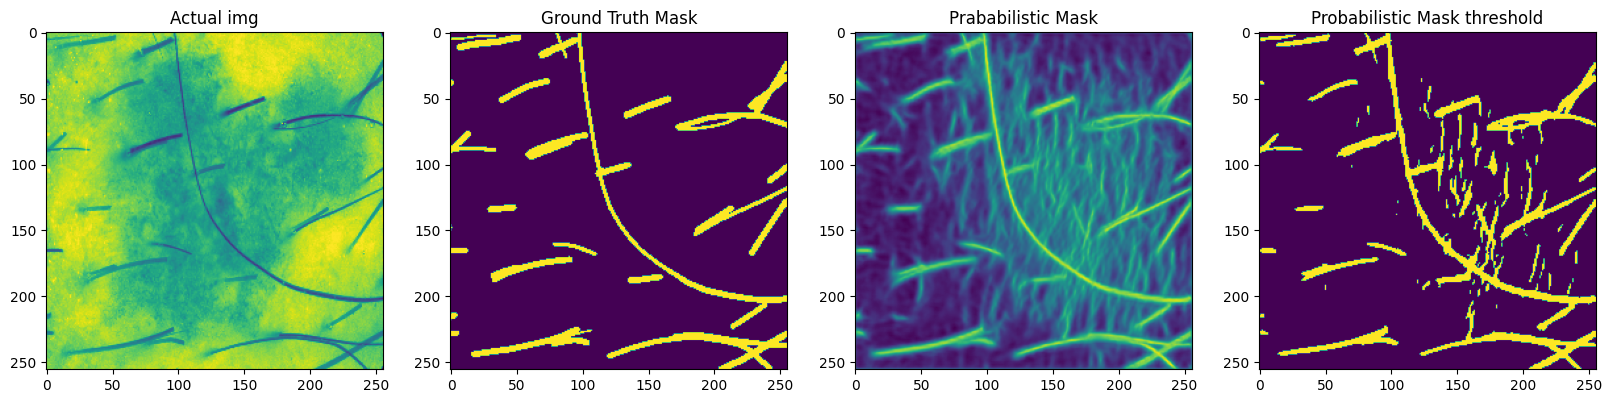

In [20]:
#plot an full image
with torch.no_grad():
    for images ,masks in val_loader :
        images = images.to(device)
        masks  = masks.to(device)

        mask_pred = net(images)
        
        img = images.cpu().numpy() 
        masks = masks.cpu().numpy()
        pred = mask_pred.cpu().numpy()
        masks_2 = (pred > 0.005).astype(int)
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 20))
        
        axes[0].imshow(img[0][0])
        axes[0].set_title('Actual img')
        
        axes[1].imshow(masks[0][0])
        axes[1].set_title('Ground Truth Mask')
        
        axes[2].imshow(pred[0][0])
        axes[2].set_title('Prababilistic Mask')
        
        axes[3].imshow(masks_2[0][0])
        axes[3].set_title('Probabilistic Mask threshold')
        break

In [21]:
# #plot a patch only
# import torch
# import matplotlib.pyplot as plt

# # Assuming net is your trained model and val_loader is your validation data loader

# with torch.no_grad():
#     for images, masks in val_loader:
#         images = images.to(device)
#         masks = masks.to(device)

#         # Perform patch-wise predictions
#         batch_size, num_patches, num_channels, height, width = images.shape
#         images = images.view(-1, num_channels, height, width)
#         masks = masks.view(-1, 1, height, width)
        
#         mask_pred = net(images)
#         mask_pred = mask_pred.view(batch_size, num_patches, 1, height, width)

#         # Aggregate patch-wise predictions into a single mask for the entire image
#         aggregated_mask_pred = mask_pred.max(dim=1)[0]  # You can choose other aggregation methods based on your use case
        
#         img = images.cpu().numpy()[0][0]
#         masks_gt = masks.cpu().numpy()[0][0]
#         masks_pred = aggregated_mask_pred.cpu().numpy()[0][0]
#         masks_thresholded = (masks_pred > 0.5).astype(int)  # Adjust the threshold as needed
        
#         fig, axes = plt.subplots(1, 4, figsize=(20, 20))

#         axes[0].imshow(img, cmap='gray')
#         axes[0].set_title('Actual img')

#         axes[1].imshow(masks_gt, cmap='gray')
#         axes[1].set_title('Ground Truth Mask')

#         axes[2].imshow(masks_pred, cmap='gray')
#         axes[2].set_title('Predicted Mask')

#         axes[3].imshow(masks_thresholded, cmap='gray')
#         axes[3].set_title('Thresholded Mask')
        
#         plt.show()
#         break
